# Creating the dataset

In [15]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PyTorchVisionLibs import utils, coco_utils, coco_eval
from PyTorchVisionLibs.engine import train_one_epoch, evaluate
from PyTorchVisionLibs import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pdb
from PIL import Image

In [16]:
train_dir = './images/keys'

In [17]:
def order_key(file): # key to order the list of images
    parts = file.split('_')
    name = parts[0]
    number = int(parts[1].split('.')[0]) 
    return name, number

In [18]:
class CustomImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = sorted(os.listdir(files_dir), key=order_key)
        #self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']

        with open('annotations_perso.json', 'r') as file:
            annotations_data = json.load(file)
        self.annotations = annotations_data['annotations']
        # classes: 0 index is reserved for background
        self.classes = [_]
        #self.classes = [_]
        
        with open('coco_categories.json', 'r') as file:
            categories_data = json.load(file)
        for category in categories_data["categories"]:
            self.classes.append(category["name"])
        
        self.classes.append('keys')
        print(self.classes)

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        #print("id: ", idx, "img_name: ", img_name)
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        boxes = []
        labels = []
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        for note in self.annotations:
            if note["image_id"] != idx:
                continue
            labels.append(note["category_id"])
            # bounding box
            xmin = int(note["bbox"][0])
            xmax = int(note["bbox"][1])
            
            ymin = int(note["bbox"][2])
            ymax = int(note["bbox"][3])

            if ymin > ymax:
                ymin, ymax = ymax, ymin

            if xmin > xmax:
                xmin, xmax = xmax, xmin

            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(xmax, wt)
            ymax = min(ymax, ht)
            
            #print("Primera note: ", note)
            #print("BOUNDING ANTES: ", xmin, xmax, ymin, ymax)
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            #print("BOUNDING DESPUES: ", xmin_corr, xmax_corr, ymin_corr, ymax_corr)
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        if len(boxes) == 0:
            boxes.append([0, 0, self.width - 0.5, self.height - 0.5])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
 
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [19]:
custom_dataset = CustomImagesDataset(train_dir, 128, 128)
print('length of dataset = ', len(custom_dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = custom_dataset[0]
print(type(img), '\n', img.shape, '\n',target)

['', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'keys']
length of dataset =  105 

<class 'numpy.ndarray'> 
 (128, 128, 3) 
 {'boxes': tensor([[ 16.5926,  14.6286, 118.5185, 113.3714

In [20]:
# Function to visualize bounding boxes in the image

def plot_image_with_boxes(img, target):
    imge = img.numpy() if isinstance(img, torch.Tensor) else img
    boxes_img = target["boxes"]
    labels_img = target["labels"]
    
    fig, ax = plt.subplots(1)
    
    ax.imshow(imge)
    
    for bbox in boxes_img:
        x_min, y_min, x_max, y_max = bbox
        wdth = x_max - x_min
        hght = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), wdth, hght, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
    for i, bbox in enumerate(boxes_img):
        x_min, y_min, _, _ = bbox
        ax.text(x_min, y_min, labels_img[i], color='red', fontsize=8, verticalalignment='top')
    
    plt.show()

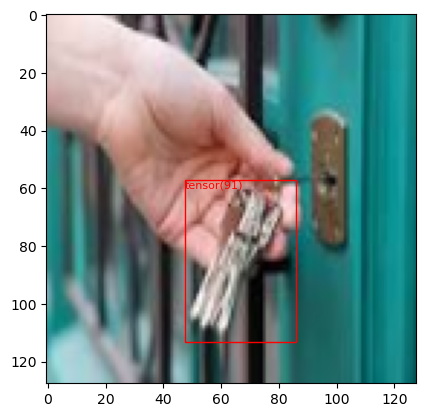

In [21]:
# plotting the image with bboxes. Feel free to change the index
img, target = custom_dataset[10]
plot_image_with_boxes(img, target)

In [22]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    print(model.roi_heads)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [28]:
def get_object_detection_model2(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    #print(model.roi_heads)
    #weights = model.state_dict()["roi_heads.box_predictor.cls_score"]
    #print(weights.shape)
    #print(model)

    for param in model.parameters():
        param.requires_grad = False
        
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    # for param in model.rpn.parameters():
    #     param.requires_grad = True
    # for param in model.roi_heads.parameters():
    #     param.requires_grad = True
    print(model.roi_heads)

    return model

In [24]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [25]:
# use our dataset and defined transformations
dataset = CustomImagesDataset(train_dir, 128, 128, transforms= get_transform(train=True))
dataset_test = CustomImagesDataset(train_dir, 128, 128, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False,
    collate_fn=utils.collate_fn)

['', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'keys']
['', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '

In [29]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 92

# get the model using our helper function
#model = get_object_detection_model(num_classes)
model = get_object_detection_model2(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to C:\Users\eduba/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|███████████████████████████████████████████████████████████████████████████████| 167M/167M [00:59<00:00, 2.94MB/s]


RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): FastRCNNConvFCHead(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [21]:
def load_model(file_path, model, optimizer=None, lr_scheduler=None):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    if lr_scheduler is not None and 'lr_scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else None
    print(f"Model loaded from {file_path}")
    
    return model, optimizer, lr_scheduler, epoch

In [22]:
model, optimizer, lr_scheduler, num_epochs = load_model('model_finetuned.pth', model, optimizer, lr_scheduler)

Model loaded from model_finetuned.pth


In [30]:
num_epochs = 8

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/21]  eta: 0:07:30  lr: 0.000255  loss: 4.9997 (4.9997)  loss_classifier: 4.8306 (4.8306)  loss_box_reg: 0.1592 (0.1592)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 21.4327  data: 0.0130
Epoch: [0]  [10/21]  eta: 0:04:07  lr: 0.002752  loss: 4.2163 (3.4459)  loss_classifier: 3.8598 (3.2546)  loss_box_reg: 0.1288 (0.1464)  loss_objectness: 0.0185 (0.0298)  loss_rpn_box_reg: 0.0075 (0.0151)  time: 22.5395  data: 0.0208
Epoch: [0]  [20/21]  eta: 0:00:22  lr: 0.005000  loss: 1.0309 (2.0995)  loss_classifier: 0.7096 (1.9062)  loss_box_reg: 0.1237 (0.1537)  loss_objectness: 0.0157 (0.0256)  loss_rpn_box_reg: 0.0093 (0.0140)  time: 22.8640  data: 0.0209
Epoch: [0] Total time: 0:07:58 (22.7963 s / it)
Epoch: [1]  [ 0/21]  eta: 0:08:11  lr: 0.005000  loss: 0.7877 (0.7877)  loss_classifier: 0.5937 (0.5937)  loss_box_reg: 0.1688 (0.1688)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 23.4224  data: 0.0170
Epoch: [1]  [10/

In [99]:
def save_model(model, optimizer, lr_scheduler, epoch, file_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Model saved in {file_path}")

save_model(model, optimizer, lr_scheduler, num_epochs, 'model_finetuned_v2.pth')

Model saved in model_finetuned_2classes.pth


In [28]:
def apply_nms(orig_prediction, iou_thresh=0.2):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [45]:
# pick one image from the test set
img, target = dataset_test[20]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  26
real #boxes:  3


EXPECTED OUTPUT


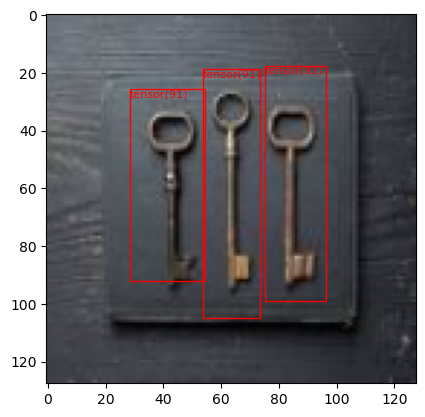

In [46]:
print('EXPECTED OUTPUT')
plot_image_with_boxes(torch_to_pil(img), target)

MODEL OUTPUT


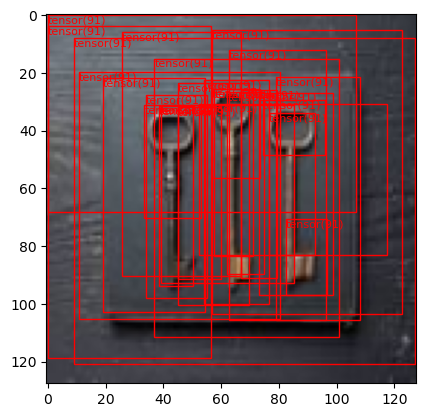

In [47]:
print('MODEL OUTPUT')
plot_image_with_boxes(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


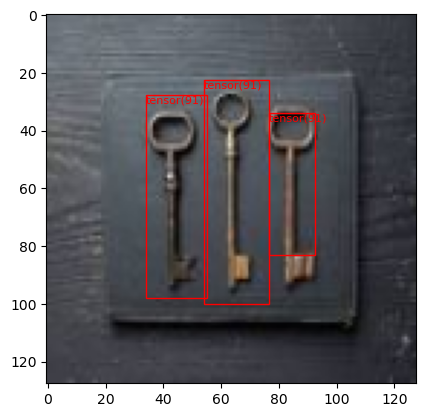

In [48]:
nms_prediction = apply_nms(prediction, iou_thresh=0.05)
print('NMS APPLIED MODEL OUTPUT')
plot_image_with_boxes(torch_to_pil(img), nms_prediction)

EXPECTED OUTPUT



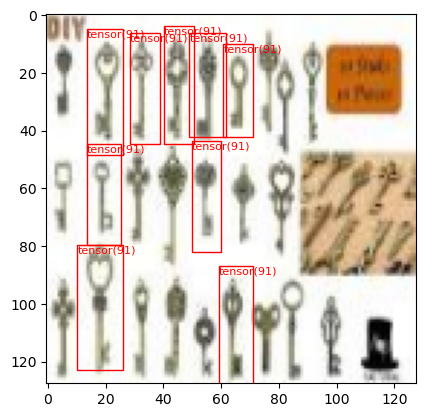

MODEL OUTPUT



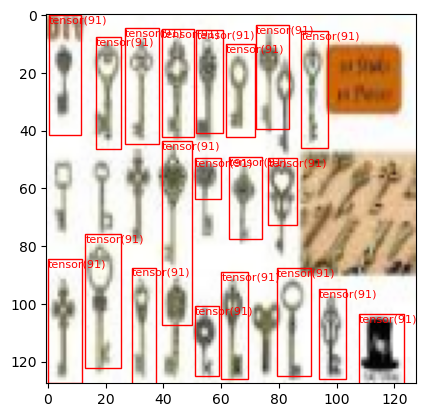

In [49]:
# pick one image from the test set
img, target = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_image_with_boxes(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_image_with_boxes(torch_to_pil(img), nms_prediction)